# Preambule

Run this code to import modules and define some functions that may result useful

In [1]:
import numpy as np
from numpy.random import MT19937, RandomState, SeedSequence
import matplotlib.pyplot as plt
import time

from sklearn.decomposition import PCA


def make_gaussian_blobs(means, covs, Ns=100, seed=42):
    ''' Create different blobs, each blob being a gaussian 
        from given mean and covariance
    '''
    rs = RandomState(MT19937(SeedSequence(seed)))
    M = min(len(means), len(covs))

    if not isinstance(Ns, list):
        aux = [Ns for _ in range(M)]
        Ns = aux
    X = np.concatenate([rs.multivariate_normal(m,
                                               cov=S,
                                               size=N)
                        for m, S, N in zip(means, covs, Ns)
                        ],
                       axis=0)
    Y = []

    for i, N in enumerate(Ns):
        Y += [i] * N

    Y = np.array(Y).ravel()

    return X, Y


def rotate_cov(A, theta):
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    return R @ A @ R.T

# Visualize data

We are using "classes" as if we knew the cluster of each point. Remember that in reality we do not know this, and are aiming at finding clusters in the data


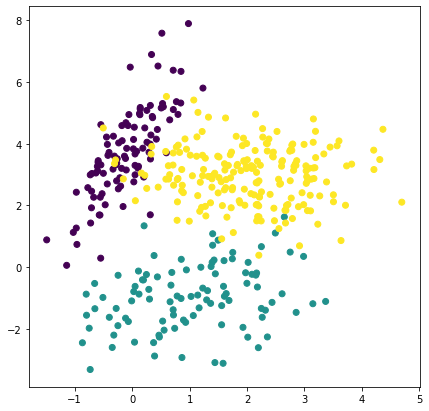

In [2]:
means = np.array([[0, 4], [1, -1], [2, 3]])
covs = [rotate_cov(np.array([[1, 0.9],
                            [0.9, 1]]),np.pi/180*30),
        rotate_cov(np.array([[1, 0.2],
                            [0.2, 1]]),np.pi/180*0),
        rotate_cov(np.array([[1, 0.1],
                            [0.1, 1]]),np.pi/180*90)
]
X, Y = make_gaussian_blobs(means, covs, Ns = [100, 100, 200], seed = 42)

fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.scatter(X[:,0], X[:,1], c = Y)

# Kmeans

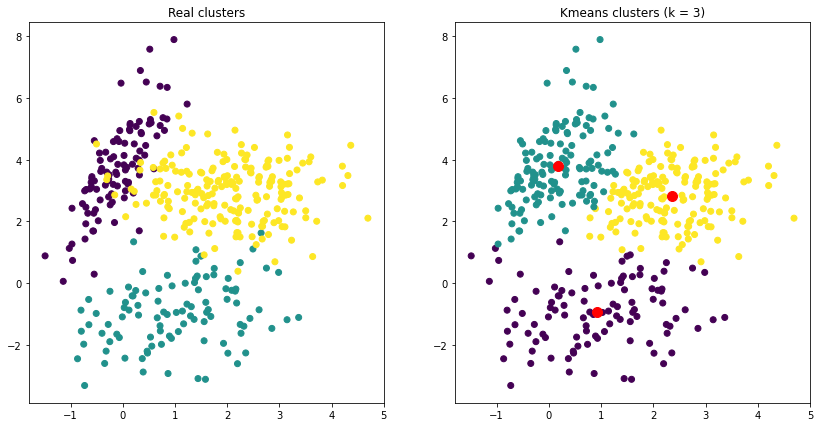

In [3]:
def compute_distances(means, X):
    # For every mean and every point, compute the distance between them
    # Size of dist_matrix is k x n (k number of clusters, n number of data points)
    dist_matrix = np.zeros((means.shape[0], X.shape[0]))
    for i in range(means.shape[0]):
        for j in range(X.shape[0]):
            dist_matrix[i, j] = np.linalg.norm(means[i] - X[j])
    return dist_matrix


def kmeans(X, k=2, seed=42):
    rs = RandomState(MT19937(SeedSequence(seed)))
    # Initialization
    # For the moment, pick random points in the dataset
    means = X[rs.choice(X.shape[0], k, replace=False), :]

    converged = False
    while not converged:
        # Compute distances and make assignments
        dist_matrix = compute_distances(means, X)
        assignments = np.argmin(dist_matrix, axis=0)
        # Compute new means based on the current assignment
        new_means = np.zeros((k, X.shape[1]))  # Compute new means
        for i in range(k):
            new_means[i] = np.mean(X[assignments == i], axis=0)
        # Check convergence
        converged = np.allclose(means, new_means)
        # Update means
        means = new_means
        # Make sure to check for some convergence condition
        # and update the variable 'converged'
    return assignments, means


k = 3
Y_kmeans, means = kmeans(X, k=k, seed=42)

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].scatter(X[:, 0], X[:, 1], c=Y)
ax[0].set_title('Real clusters')
ax[1].scatter(X[:, 0], X[:, 1], c=Y_kmeans)
ax[1].set_title(f'Kmeans clusters (k = {k})')
for i in range(k):
    ax[1].scatter(means[i, 0], means[i, 1], c='red', s=100)

# Gaussian Mixture


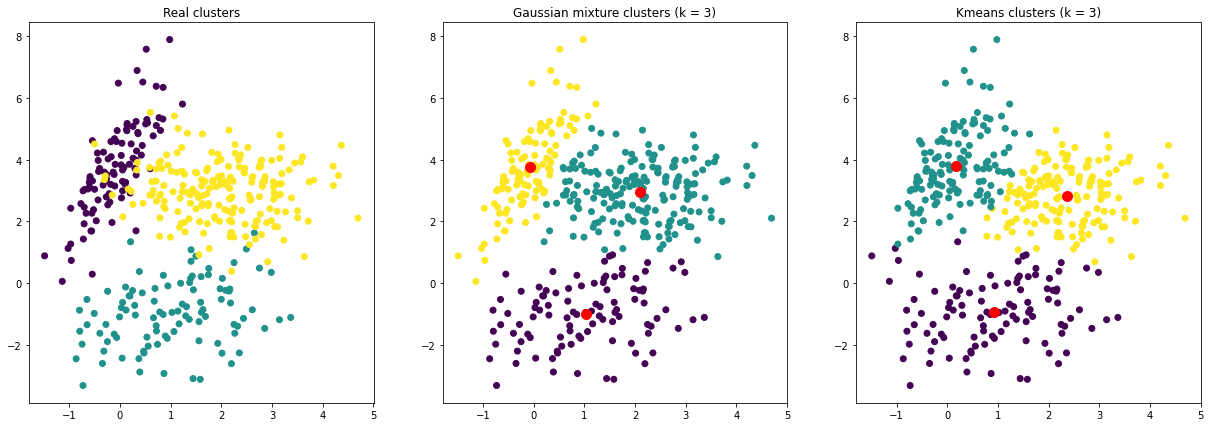

In [4]:
from scipy.stats import multivariate_normal


def likelihood_vectors(means, covs, pi, X):
    n, d = X.shape
    # Shape of likelihood matrix is n x k
    likelihood = np.zeros((n, len(means)))
    for i in range(n):
        for j in range(len(means)):
            likelihood[i, j] = pi[j] * multivariate_normal.pdf(X[i], means[j], covs[j])
    return likelihood


def gaussian_mixture(X, k=2, seed=42):
    rs = RandomState(MT19937(SeedSequence(seed)))
    # Initialization
    # For the moment, pick random points in the dataset
    n, d = X.shape
    means = X[rs.choice(X.shape[0], k, replace=False), :]

    # Start with identity convariances matrices
    covs = [np.eye(d) for _ in range(k)]

    # Uniform pi
    pi = np.ones(k) / k

    converged = False
    while not converged:
        # E step
        # Compute responsability r
        likelihood = likelihood_vectors(means, covs, pi, X)
        responsability = likelihood / np.sum(likelihood, axis=1).reshape(-1, 1)

        # M step
        # Compute new parameters based on the current assignment
        new_means = np.zeros((k, d))
        new_covs = [np.zeros((d, d)) for _ in range(k)]
        new_pi = np.zeros(k)
        for i in range(k):
            new_means[i] = np.sum(responsability[:, i].reshape(-1, 1) * X, axis=0) / np.sum(responsability[:, i])
            new_covs[i] = (responsability[:, i].reshape(-1, 1) * (X - new_means[i])).T @ (X - new_means[i]) / np.sum(
                responsability[:, i])
            new_pi[i] = np.sum(responsability[:, i]) / n

        # Check convergence
        converged = np.allclose(means, new_means) and np.allclose(covs, new_covs) and np.allclose(pi, new_pi)

        # Update parameters
        means = new_means
        covs = new_covs
        pi = new_pi

        # Make sure to check for some convergence condition
        # and update the variable 'converged'

    return responsability, likelihood


k = 3
Y_gm, _ = gaussian_mixture(X, k=k, seed=42)
Y_gm_hard = Y_gm.argmax(1)

fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax[0].scatter(X[:, 0], X[:, 1], c=Y)
ax[0].set_title('Real clusters')

ax[1].scatter(X[:, 0], X[:, 1], c=Y_gm_hard)
ax[1].set_title(f'Gaussian mixture clusters (k = {k})')
for i in range(k):
    mean = X[Y_gm_hard == i, :].mean(axis=0)
    ax[1].scatter(mean[0], mean[1], c='red', s=100)

ax[2].scatter(X[:, 0], X[:, 1], c=Y_kmeans)
ax[2].set_title(f'Kmeans clusters (k = {k})')
for i in range(k):
    mean = X[Y_kmeans == i, :].mean(axis=0)
    ax[2].scatter(mean[0], mean[1], c='red', s=100)


# Some exercises with K-means and Gaussian Mixture

## Plot the evolution of the means in k means

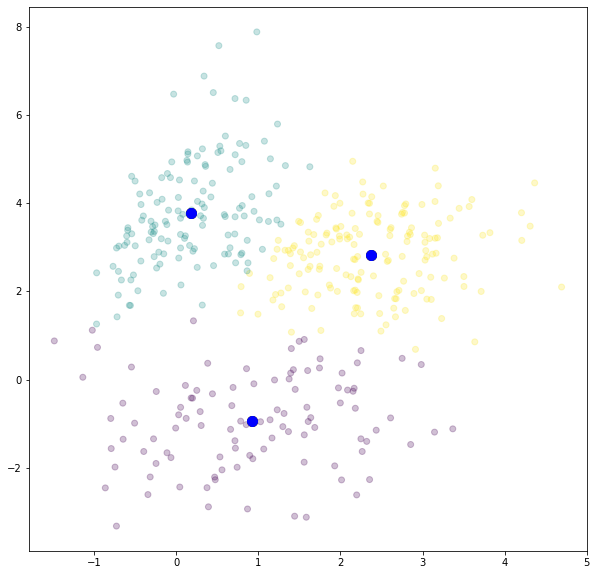

In [5]:
k = 3
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(X[:, 0], X[:, 1], c=Y_kmeans, alpha=0.25)
for i in range(k):
    ax.scatter(means[i, 0], means[i, 1], c='red', s=100)
    ax.scatter(means[i, 0], means[i, 1], c='green', s=100)
    ax.scatter(means[i, 0], means[i, 1], c='blue', s=100)

## Measure the intra-cluster distance for different values of k and plot it

Text(0.5, 1.0, 'Intra-cluster distance for different values of k')

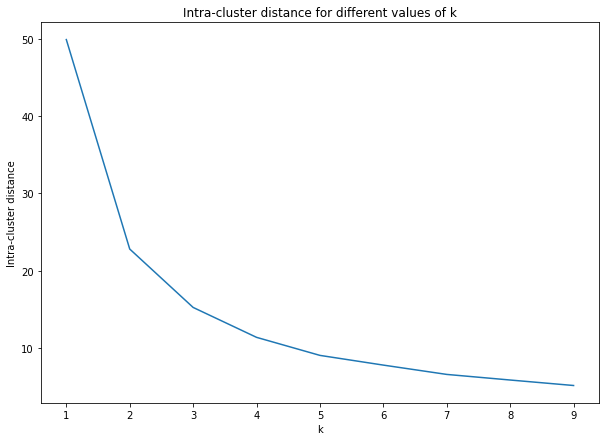

In [6]:
ks = np.arange(1, 10)
intra_cluster_distances = []
for k in ks:
    Y_kmeans, means = kmeans(X, k=k, seed=42)
    intra_cluster_distances.append(np.mean([np.linalg.norm(X[Y_kmeans == i] - means[i]) for i in range(k)]))

fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(ks, intra_cluster_distances)
plt.xlabel('k')
plt.ylabel('Intra-cluster distance')
plt.title('Intra-cluster distance for different values of k')

Text(0.5, 1.0, 'Total likelihood for different values of k')

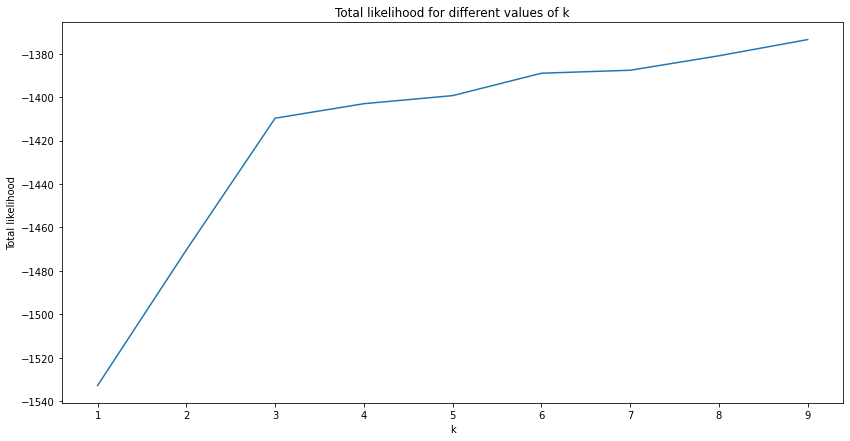

In [7]:
ks = np.arange(1, 10)
total_likelihoods = []
for k in ks:
    _, likelihood = gaussian_mixture(X, k=k, seed=42)
    total_likelihoods.append(np.sum(np.log(np.sum(likelihood, axis=1))))

fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(ks, total_likelihoods)
plt.xlabel('k')
plt.ylabel('Total likelihood')
plt.title('Total likelihood for different values of k')

# Hierarchical clustering
Implement the different cluster similarity metrics and the CHA algorithm (Clustering Hiérarchique Ascendante).

Implement the different measures of clustering quality to evaluate the different clustering levels and choose the best one

In [ ]:
# For all distances we assume the clusters are given as numpy arrays
# The dimensions of the arrays are NxD where N is the number of points
# and D is the dimension of the vectors

def nearest_neighbor(A, B):
    dmin = np.inf
    for a in A:
        for b in B:
            d = np.linalg.norm(a - b)
            if d < dmin:
                dmin = d
    return dmin


def maximum_diameter(A, B):
    dmax = 0.0
    for a in A:
        for b in B:
            d = np.linalg.norm(a - b)
            if d > dmax:
                dmax = d
    return dmax


def average_distance(A, B):
    na, nb = A.shape[0], B.shape[0]
    dtot = 0.0
    for a in A:
        for b in B:
            dtot += np.linalg.norm(a - b)
    return dtot


def ward_distance(A, B):
    na, nb = A.shape[0], B.shape[0]
    return np.sqrt((na * nb) / (na + nb)) * np.linalg.norm(A.mean(0) - B.mean(0))


def CHA(X, dist_func):
    N, d = X.shape
    Y_historic = np.zeros((N, N))
    Y = np.arange(N)
    Y_historic[:, 0] = Y.copy()
    for c in range(N, 1, -1):
        # For current clustering Y, compute distances between clusters
        D = np.zeros((c, c))
        for i in range(c):
            for j in range(i + 1, c):
                ind_i = (Y == i)
                ind_j = (Y == j)
                D[i, j] = dist_func(X[ind_i], X[ind_j])
                D[j, i] = D[i, j]

        # Find the two clusters ca, cb that are the most similar
        ca, cb = np.unravel_index(np.argmin(D), D.shape)
        # Join the clusters ca and cb
        Y[Y == cb] = ca
        # Update the historic of clusterings
        Y_historic[:, N - c] = Y.copy()

    return Y_historic


def clusters_to_1N_range(Y):
    # Auxiliary function just for plotting
    if len(Y.shape) == 1:
        aux = Y.reshape(-1, 1)
    else:
        aux = Y
    d = aux.shape[1]
    res = np.zeros_like(aux)
    for j in range(d):
        u = np.unique(aux[:, j])
        for i, k in enumerate(u):
            ind = (aux[:, j] == k)
            res[ind, j] = i
    return res

In [ ]:
# Metric
def inertia_intra(X, Y):
    inertia = 0.0
    for i in range(Y.max() + 1):
        ind = (Y == i)
        inertia += np.sum(np.linalg.norm(X[ind] - X[ind].mean(0), axis=1) ** 2)
    return inertia

def inertia_inter(X, Y):
    mu = X.mean(0)
    inertia = 0.0
    for i in range(Y.max() + 1):
        ind = (Y == i)
        inertia += np.sum(np.linalg.norm(X[ind] - mu, axis=1) ** 2)
    return inertia

## Try CHA with a simple dataset
Let us create a new dataset where members of each cluster are more concentrated between them and more separated from members of other clusters.
Use a small number of points


In [ ]:
# We use the same gaussians but multiplying the convariance matrices by a small number
means = np.array([[0, 4], [1, -1], [2, 3]])
covs = [rotate_cov(np.array([[1, 0.9],
                            [0.9, 1]])*0.2,np.pi/180*30),
        rotate_cov(np.array([[1, 0.2],
                            [0.2, 1]])*0.2,np.pi/180*0),
        rotate_cov(np.array([[1, 0.1],
                            [0.1, 1]])*0.2,np.pi/180*90)
]

n = 5
X, Y = make_gaussian_blobs(means, covs, Ns = [n, n, 2*n], seed = 42)

fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.scatter(X[:,0], X[:,1], c = Y)

In [ ]:
# Choose a distance function here
dist_func = nearest_neighbor
dist_func = maximum_diameter
dist_func = average_distance
# dist_func = ward_distance


start = time.time()
Y_CHA = CHA(X, dist_func)
end = time.time()
print(f"Clustering done. Time taken: {end - start} sec")


In [ ]:
# Choose a metric to evaluate clustering
metric = inertia_intra
# metric = inertia_inter

metrics = []

for i in range(Y_CHA.shape[1]):
    metrics.append(metric(X, Y_CHA[:, i]))

metrics = np.array(metrics[::-1])


In [ ]:
# Plot the metric difference ratios to select best clustering constant
aux = np.diff(metrics)
header = " | ".join([f"{'K': ^8}", f"{'ratio': ^8}", f"{'Diff(K-1)': ^8}", f"{'Diff(K)': ^8}"])
print(header)
print('-'*len(header))
for i, x in enumerate(aux[:-1]/aux[1:]):
    if i > 10: break
    print(f"{i+2: ^8}", f"{100*x: ^8.2f}", f"{aux[i]: ^8.2f}", f"{aux[i+1]: ^8.2f}", sep=" | ")

In [ ]:
N = X.shape[0]

c = 3


step = 1
xr = np.arange(1, N+1, step)

fig, ax = plt.subplots(1,2,figsize = (14,6))
ax[0].plot(xr, metrics)
ax[0].scatter(xr, metrics, s = 70)
ax[0].set_xticks(xr)
ax[0].set_xticklabels(xr)
ax[0].set_title(f"Metric: {metric.__name__}")
ax[0].set_xlabel(f"Number of clusters")
ax[0].set_ylabel(f"Inertia")


ax[1].scatter(X[:,0], X[:,1], c = Y_CHA[:, N-c], cmap = 'jet')
ax[1].set_title(f"CHA with {dist_func.__name__} distance, {c} clusters")

## Now with the original dataset

**Remark!**
CHA is very time consumig, we will resample from our distribution but using less points



In [ ]:
means = np.array([[0, 4], [1, -1], [2, 3]])
covs = [rotate_cov(np.array([[1, 0.9],
                            [0.9, 1]]),np.pi/180*30),
        rotate_cov(np.array([[1, 0.2],
                            [0.2, 1]]),np.pi/180*0),
        rotate_cov(np.array([[1, 0.1],
                            [0.1, 1]]),np.pi/180*90)
]

n = 20
X, Y = make_gaussian_blobs(means, covs, Ns = [n, n, 2*n], seed = 42)

fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.scatter(X[:,0], X[:,1], c = Y)

In [ ]:
# dist_func = nearest_neighbor
# dist_func = maximum_diameter
dist_func = average_distance
# dist_func = ward_distance


start = time.time()
Y_CHA = CHA(X, dist_func)
end = time.time()
print(f"Clustering done. Time taken: {end - start} sec")


In [ ]:
# Choose a metric to evaluate clustering
metric = inertia_intra
metric = inertia_inter

metrics = []

for i in range(Y_CHA.shape[1]):
    metrics.append(metric(X, Y_CHA[:, i]))

metrics = np.array(metrics[::-1])


In [ ]:
# Plot the metric difference ratios to select best clustering constant
aux = np.diff(metrics)
header = " | ".join([f"{'K': ^8}", f"{'ratio': ^8}", f"{'Diff(K-1)': ^8}", f"{'Diff(K)': ^8}"])
print(header)
print('-'*len(header))
for i, x in enumerate(aux[:-1]/aux[1:]):
    if i > 10: break
    print(f"{i+2: ^8}", f"{100*x: ^8.2f}", f"{aux[i]: ^8.2f}", f"{aux[i+1]: ^8.2f}", sep=" | ")

In [ ]:
N = X.shape[0]


fig, ax = plt.subplots(1,2,figsize = (14,6))

max_c = 10

ax[0].plot(np.arange(1, max_c+1, 1), metrics[:max_c])
ax[0].scatter(np.arange(1, max_c+1, 1), metrics[:max_c])

step = 1
xr = np.arange(1, max_c+1, step)
ax[0].set_xticks(xr)
ax[0].set_xticklabels(xr)
ax[0].set_title(f"Metric: {metric.__name__}")
ax[0].set_xlabel(f"Number of clusters")
ax[0].set_ylabel(f"Inertia")


c = 2

ax[1].scatter(X[:,0], X[:,1], c = clusters_to_1N_range(Y_CHA[:, N-c]), cmap = 'nipy_spectral')
ax[1].set_title(f"CHA with {dist_func.__name__} distance, {c} clusters")